In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils.extmath import randomized_svd

import hapod as hp


In [2]:
#specs for the snapshots matrix
n_rows = 5000
n_cols = 2000
dtype = np.float64

#simulate the maximum size of a single SVD for this machine
rank_max = 200

#fix the random generator
rng = np.random.default_rng(42)

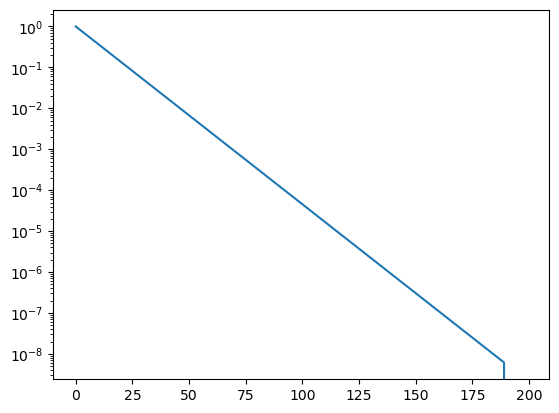

In [3]:
#prepare an array of singular values that exhibits a good decay
ranks = np.arange(0, n_cols)
# s_true = np.exp(np.exp(-ranks / 20)).astype(dtype)

s_true = np.exp(- 0.1 * ranks).astype(dtype)
s_true[rank_max - 10:] = 0

plt.semilogy(s_true[:rank_max])

plt.show()
plt.close()

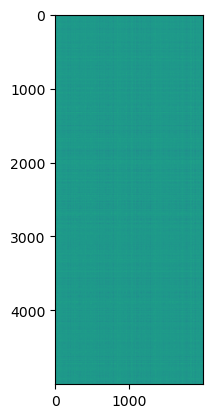

In [4]:
#build random U and V to construct the snapshots matrix
U_true, _ = np.linalg.qr(rng.random((n_rows, n_cols), dtype=dtype))
V_true, _ = np.linalg.qr(rng.random((n_cols, n_cols), dtype=dtype))
X = U_true @ np.diag(s_true) @ V_true.T

plt.imshow(X)

plt.show()
plt.close()

In [5]:
#exact POD of the snapshots, truncated to rank_max
U_np, s_np = hp.get_pod(X, rank_max=rank_max)

In [6]:
#check that the singular values are those we set during construction
assert np.allclose(s_np, s_true[:rank_max])

In [7]:
#randomized POD of the snapshots
#this still uses the full X when computing the singular values
U_rand, s_rand, _ = randomized_svd(X, 
                                   n_components=rank_max, 
                                   n_oversamples=0,
                                   random_state=42,
                                   )

In [8]:
#randomized POD of the snapshots
#this simulates that rank_max columns were extracted
# random_samples = rng.choice(n_cols, rank_max, replace=False)
# U_rand, s_rand = hp.get_pod(X[:, random_samples], rank_max=rank_max)
U_rand, s_rand = hp.randomized_POD_on_disk(np.array_split(X, n_cols, axis=1),
                                           rank_max=rank_max,
                                           serializer=hp.InMemorySerializer(),
                                           randomizer_rng=rng)

In [9]:
#prepare the chunks for hapod
#each chunk must be at most half the size of rank_max
chunk_rank_max = rank_max // 2

#tune the number of chunks so that the tree of merges will be full
n_chunks = hp.get_n_chunks_fulltree(n_cols, 
                                    n_chunk_max_cols=chunk_rank_max)

#build a list of chunks; starting from the single snapshots
#here, the chunks will be kept in memory, while the default behavior is to store them on disk
Xs = hp.make_chunks(np.array_split(X, n_cols, axis=1),
                    ".",
                    n_chunks=n_chunks,
                    serializer=hp.InMemorySerializer(),
                    # randomizer_rng=rng,
                    )

verbose = True

In [10]:
#perform hapod keeping the intermediate results in memory
U_hp, s_hp = hp.hapod(Xs,
                      chunk_rank_max=chunk_rank_max,
                      serializer=hp.InMemorySerializer(),
                      verbose=verbose,
                      )

Xs
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 63), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), dtype('float64'))
    ((5000, 62), 

In [11]:
#randomized HAPOD
random_samples = rng.choice(n_cols, rank_max, replace=False)
U_hp_rand, s_hp_rand = hp.hapod([X[:, random_samples]],
                      chunk_rank_max=chunk_rank_max,
                      serializer=hp.InMemorySerializer(),
                      verbose=verbose,
                      )

Xs
    ((5000, 200), dtype('float64'))
last chunk
    ((5000, 200), dtype('float64'))
    U.shape (5000, 200)
    took 0.098


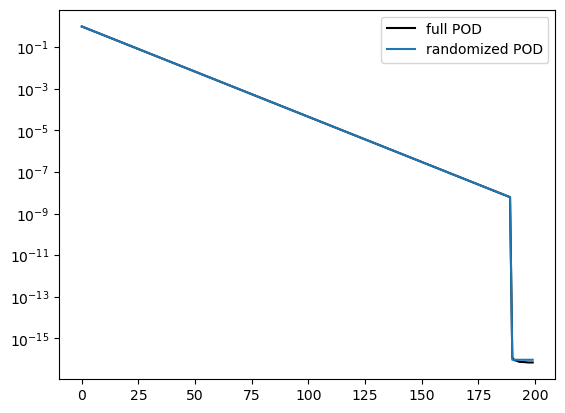

In [15]:
#compare the singular values
plt.semilogy(s_np, label="full POD", c="black")
plt.semilogy(s_rand, label="randomized POD")
# plt.semilogy(s_hp, label="HAPOD")
# plt.semilogy(s_hp_rand, label="randomized HAPOD")
# plt.semilogy(s_hp_file, label="hapod file")

plt.legend()

plt.show()
plt.close()

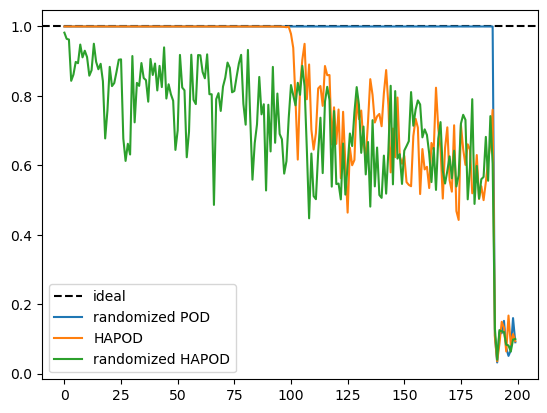

In [16]:
ortho_rand = np.max(np.abs(U_rand.T @ U_np), axis=0)
ortho_hp = np.max(np.abs(U_hp.T @ U_np), axis=0)
ortho_hp_rand = np.max(np.abs(U_hp_rand.T @ U_np), axis=0)

plt.axhline(1, linestyle="--", c="black", label="ideal")

plt.plot(ortho_rand, label="randomized POD")
plt.plot(ortho_hp, label="HAPOD")
plt.plot(ortho_hp_rand, label="randomized HAPOD")

plt.legend()

plt.show()
plt.close()

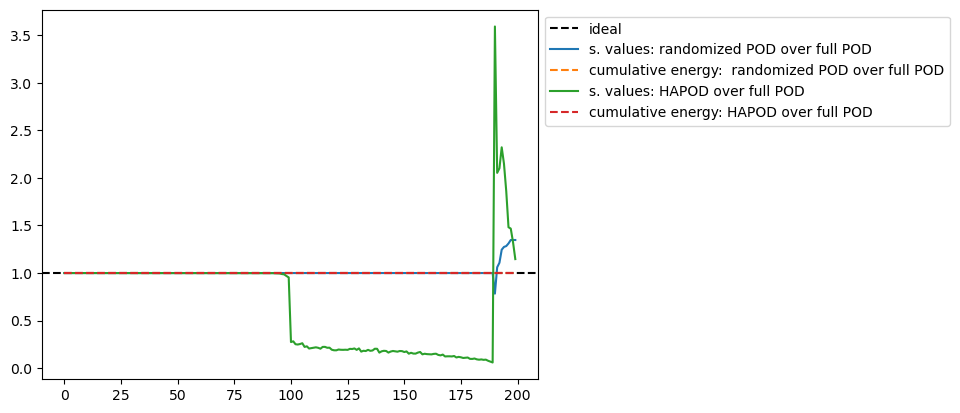

In [14]:

plt.axhline(1, linestyle="--", c="black", label="ideal")

plt.plot(s_rand / s_np, 
         label="s. values: randomized POD over full POD")
plt.plot(hp.get_cumulative_energy_ratios(s_rand)
            / hp.get_cumulative_energy_ratios(s_np),
         linestyle="--",
         label="cumulative energy:  randomized POD over full POD")

plt.plot(s_hp / s_np, 
         label="s. values: HAPOD over full POD")
plt.plot(hp.get_cumulative_energy_ratios(s_hp)
            / hp.get_cumulative_energy_ratios(s_np),
         linestyle="--",
         label="cumulative energy: HAPOD over full POD")


plt.legend(loc="upper left", 
           bbox_to_anchor=(1, 1))

plt.show()
plt.close()